Module importieren

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from fitter import Fitter
import numpy as np
from scipy import stats
import statsmodels.api as sm
from tabulate import tabulate

Daten laden und säubern

In [2]:
def open_csv_to_df(directory):
    df = pd.read_csv(directory)
    df = df.iloc[0:,:4]
    df.columns = ["Date", "Time", "Mass_(kg)", "Velocity_(m/s)"]
    #df_energy = pd.DataFrame()
    df.insert(4, "Energy", "")
    df.insert(5, "Date_and_Time", "")
    df.insert(6, "Time_delta_(h)", "")
    for i in range(len(df)):
        df.iloc[i,4] = 0.5 * float(df.iloc[i,2]) * float(df.iloc[i,3]) ** 2 / 1000 #calculation of Energy
    df = df.sort_values(['Date', 'Time']).reset_index(drop=True)
    df = df.dropna()

    for i in range(len(df)):
        date_raw = df.iloc[i,:].Date +" " +df.iloc[i,:].Time
        date1 = datetime.strptime(date_raw, '%Y-%m-%d %H:%M')
        df.iloc[i,5] = date1

    for i in range(len(df)-1):
        date1 = df.iloc[i,5]
        date2 = df.iloc[i+1,5]
        time_delta = date2 - date1
        time_delta = (time_delta.days*24) + (time_delta.seconds//3600)
        df.iloc[i+1,6] = time_delta

    #Fitter kann keine NAs handhaben aus diesem Grund wird erste Beobachtung mit dem Median der Zeitabstände ersetzt.
    df.iloc[0,6] = 0
    df['Time_delta_(h)'] = df['Time_delta_(h)'].astype('int')
    df.iloc[0,6] = df["Time_delta_(h)"].median()

    return df #this is the table with all stones combined

In [4]:
df1 = open_csv_to_df("./out_1.csv")
df2 = open_csv_to_df("./out_2.csv")

In [20]:
df1.dtypes

Date               object
Time               object
Mass_(kg)         float64
Velocity_(m/s)    float64
Energy             object
Date_and_Time      object
Time_delta_(h)      int32
dtype: object

In [21]:
df1.head(5)

,Date,Time,Mass_(kg),Velocity_(m/s),Energy,Date_and_Time,Time_delta_(h)
0,2019-01-01,09:00,194.0,8.4,6.84432,2019-01-01 09:00:00,22
1,2019-01-01,21:00,224.0,8.8,8.67328,2019-01-01 21:00:00,12
2,2019-01-02,14:00,3104.0,9.2,131.36128,2019-01-02 14:00:00,17
3,2019-01-04,15:00,228.0,8.0,7.296,2019-01-04 15:00:00,49
4,2019-01-05,23:00,755.0,7.0,18.4975,2019-01-05 23:00:00,32


In [23]:
df2.dtypes

Date               object
Time               object
Mass_(kg)         float64
Velocity_(m/s)    float64
Energy             object
Date_and_Time      object
Time_delta_(h)    float64
dtype: object

In [22]:
df2.head(5)

,Date,Time,Mass_(kg),Velocity_(m/s),Energy,Date_and_Time,Time_delta_(h)
0,2019-01-01,09:00,38.0,45.4,39.16204,2019-01-01 09:00:00,48.5
1,2019-01-03,06:00,187.0,41.6,161.80736,2019-01-03 06:00:00,45.0
2,2019-01-04,10:00,36.0,44.6,35.80488,2019-01-04 10:00:00,28.0
3,2019-01-07,14:00,6.0,41.2,5.09232,2019-01-07 14:00:00,76.0
4,2019-01-11,06:00,65.0,39.6,50.9652,2019-01-11 06:00:00,88.0


In [66]:
def boxplot_compare(dataframe_1, dataframe_2, column, title):
    plt.figure(figsize=(8, 6), dpi=80)
    fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols =  2)
    ax1.boxplot(dataframe_1[column])
    ax2.boxplot(dataframe_2[column])
    ax1.set_xticks([])
    ax2.set_xticks([])
    fig.suptitle(title, fontsize=16)
    ax1.set_title("Dataframe 1")
    ax1.set_ylabel(column)
    ax2.set_title('Dataframe 2')
    plt.show()

<Figure size 640x480 with 0 Axes>

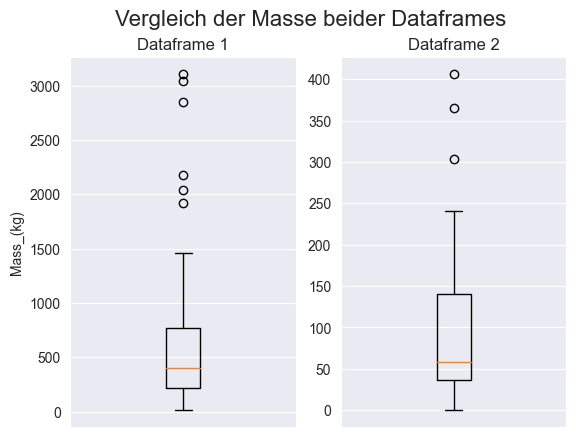

In [67]:
boxplot_compare(df1,df2,"Mass_(kg)", "Vergleich der Masse beider Dataframes")

<Figure size 640x480 with 0 Axes>

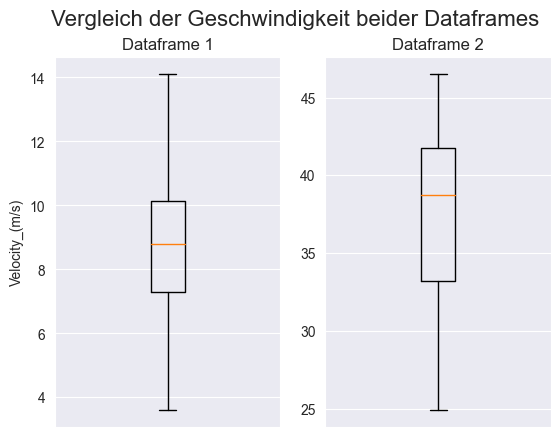

In [68]:
boxplot_compare(df1,df2,"Velocity_(m/s)", "Vergleich der Geschwindigkeit beider Dataframes")

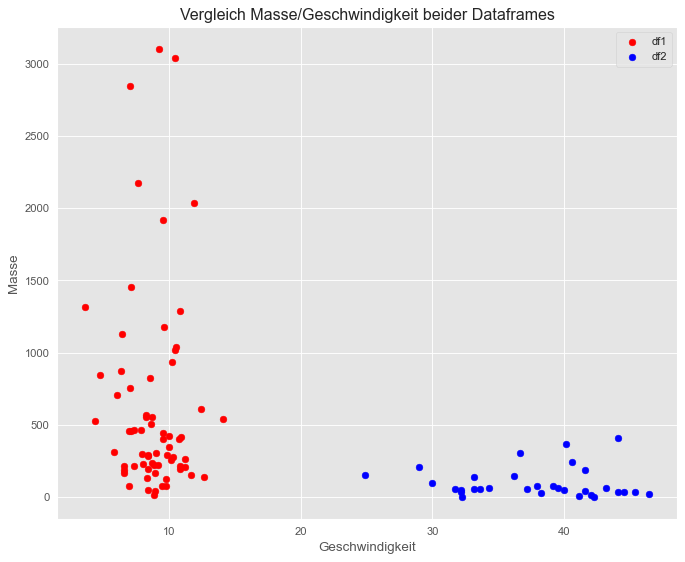

In [101]:
plt.figure(figsize=(10, 8), dpi=80)
plt.style.use('ggplot')
plt.title("Vergleich Masse/Geschwindigkeit beider Dataframes")
plt.xlabel("Geschwindigkeit")
plt.ylabel("Masse")
plt.scatter(x = df1["Velocity_(m/s)"],y = df1["Mass_(kg)"], color = "red", label = "df1")
plt.scatter(x = df2["Velocity_(m/s)"],y = df2["Mass_(kg)"], color = "blue", label = "df2")

plt.legend(loc='upper right')
plt.show()

Funktion für Fitting von Verteilungen

In [ ]:
def fit_distribution(data):
    count = 0
    fitted_mass = Fitter(data)
    fitted_mass.fit()
    ks_summary = fitted_mass.summary()
    distributions = ks_summary.index.values
    print(ks_summary.iloc[:,-2:])
    fig, ax = plt.subplots(1,5,figsize=(25, 5))
    table = [['Distribution', 'Parameters']]


    for i in distributions:
        param = fitted_mass.fitted_param[i]
        table.append([i, param])
        dist_eval = eval('stats.' + i + '.rvs(*param, size = 1000)')
        sm.qqplot_2samples(data, dist_eval, xlabel = i.capitalize() + ' Distribution', ylabel = 'Sample Distribution', line = '45' ,ax = ax[count])
        count += 1
    plt.show()
    print(tabulate(table, headers = 'firstrow'))

Zone 1

In [ ]:
#fit_distribution(df1['Mass_(kg)'])

In [ ]:
#fit_distribution(df1["Velocity_(m/s)"])

In [ ]:
#fit_distribution(df1["Time_delta_(h)"])

Zone 2

In [ ]:
#fit_distribution(df2['Mass_(kg)'])

In [ ]:
#fit_distribution(df2["Velocity_(m/s)"])

In [ ]:
fit_distribution(df2["Time_delta_(h)"])

Monte Carlo

In [ ]:
def plot_verteilung(dataframe, x_val):
    sns.set_style("white")
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)

Zone 1

In [ ]:
mass1_sim = stats.norminvgauss.rvs(3.1212660746620413, 3.049636729092045, 34.65446329649014, 129.49172019279249, size = 10000)
df1_mass_sim = pd.DataFrame(mass1_sim)
#df1_mass_sim[df1_mass_sim[0] < 0][0]

In [ ]:
velocity1_sim = stats.norminvgauss.rvs(8.815229190843102, -1.1717104407578982, 9.56468292816113, 5.789676074259544, size = 10000)
df1_velocity_sim = pd.DataFrame(velocity1_sim)

In [ ]:
timedelta1_sim = stats.chi.rvs(0.6466917035616518, -8.620646255400194e-27, 50.086113926689904, size = 1000000)
df1_timedelta_sim = pd.DataFrame(timedelta1_sim)

Zone 2

In [ ]:
mass2_sim = stats.skewcauchy.rvs(0.5654845478523323, 31.009036433794673, 28.383685799048294, size = 1000000)
df2_mass_sim = pd.DataFrame(mass2_sim)

In [ ]:
velocity2_sim = stats.beta.rvs(2.135456049863241, 1.2827668923945292, 23.092130432299154, 23.56888476645474, size = 1000000)
df2_velocity_sim = pd.DataFrame(velocity2_sim)

In [ ]:
timedelta2_sim = stats.expon.rvs(7.0, 59.322580645161295, size = 1000000)
df2_timedelta_sim = pd.DataFrame(timedelta2_sim)